In [2]:
import re
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
import joblib
import matplotlib.pyplot as plt

In [3]:
data_overview = pd.read_csv('./Data/movies_overview.csv')
data_tags = pd.read_csv('./Data/movies_genres.csv')
data_overview.head()

,title,overview,genre_ids
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"[18, 80]"
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","[18, 80]"
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[18, 80]"
3,Schindler's List,The true story of how businessman Oskar Schind...,"[18, 36, 10752]"
4,12 Angry Men,The defense and the prosecution have rested an...,[18]


In [4]:
data_tags.head()
tag_map = dict(zip(data_tags['id'], data_tags['name']))
print(tag_map)

{28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}


In [5]:
if isinstance(data_overview['genre_ids'].iloc[0], str):
    data_overview['genre_ids'] = data_overview['genre_ids'].apply(ast.literal_eval)

In [6]:
def ids_to_names(tag_id_str):
    return [tag_map.get(tag_id, "UNKNOWN") for tag_id in tag_id_str]
    

In [7]:
data_overview['tag_names'] = data_overview['genre_ids'].apply(ids_to_names)

In [8]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [9]:
data_overview['overview'] = data_overview['overview'].apply(clean_text)
data_overview['title'] = data_overview['title'].apply(clean_text)   

In [10]:
mlb = MultiLabelBinarizer()
y = pd.DataFrame(mlb.fit_transform(data_overview['tag_names']), columns=mlb.classes_)

In [11]:
#creating features varients
#overview only
x = data_overview['overview']
#title and overview
xt = (data_overview['title'] + ' ').str.strip() + ' ' + data_overview['overview']

In [ ]:
results = []

def upsample_multilabel(X, Y, target='median', random_state=42):
    """Upsample rows in X/Y (multi-label) so minority labels reach the target count."""
    # X: pd.Series or pd.DataFrame (rows of text), Y: pd.DataFrame (one-hot labels)
    counts = Y.sum()
    if target == 'median':
        tgt = int(counts.median())
    elif target == 'max':
        tgt = int(counts.max())
    else:
        tgt = int(target)
    # nothing to do
    if tgt <= counts.min():
        return X.reset_index(drop=True), Y.reset_index(drop=True)
    X = X.reset_index(drop=True)
    Y = Y.reset_index(drop=True)
    rows_to_add = []
    rng = np.random.RandomState(random_state)
    for label in Y.columns:
        c = counts[label]
        if c == 0 or c >= tgt:
            continue
        needed = tgt - int(c)
        idxs = Y[Y[label] == 1].index.tolist()
        if not idxs:
            continue
        sampled = rng.choice(idxs, size=needed, replace=True)
        rows_to_add.extend(sampled.tolist())
    if not rows_to_add:
        return X, Y
    X_add = X.iloc[rows_to_add].reset_index(drop=True)
    Y_add = Y.iloc[rows_to_add].reset_index(drop=True)
    X_new = pd.concat([X, X_add], ignore_index=True)
    Y_new = pd.concat([Y, Y_add], ignore_index=True)
    # shuffle
    perm = rng.permutation(len(X_new))
    X_new = X_new.iloc[perm].reset_index(drop=True)
    Y_new = Y_new.iloc[perm].reset_index(drop=True)
    return X_new, Y_new

def train_model(x, y, data_name):
    
    x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

    # Upsample minority labels in the training set to median label count
    x_train, y_train = upsample_multilabel(x_train, y_train, target='median', random_state=42)
    print('After upsampling train label counts:\n', y_train.sum().sort_values(ascending=False))

    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')),
        ('clf', OneVsRestClassifier(LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1, class_weight='balanced')))
    ])
    
    print(f"Train set size: {len(x_train)}")
    print(f"Validation set size: {len(x_val)}")
    print(f"Test set size: {len(x_test)}")  
    print(f"Number of classes: {len(y.columns)}")


    pipe.fit(x_train, y_train)

    y_valid_pred = pipe.predict(x_val)
    y_test_pred = pipe.predict(x_test)

    val_micro_f1 = f1_score(y_val, y_valid_pred, average='micro')
    val_macro_f1 = f1_score(y_val, y_valid_pred, average='macro')
    val_hamming_loss = hamming_loss(y_val, y_valid_pred)
    val_accuracy = accuracy_score(y_val, y_valid_pred)

    print(f"Validation Micro F1: {val_micro_f1}")
    print(f"Validation Macro F1: {val_macro_f1}")
    print(f"Validation Hamming Loss: {val_hamming_loss}")
    print(f"Validation Accuracy: {val_accuracy}")

    test_micro_f1 = f1_score(y_test, y_test_pred, average='micro')
    test_macro_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_hamming_loss = hamming_loss(y_test, y_test_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Micro F1: {test_micro_f1}")
    print(f"Test Macro F1: {test_macro_f1}")
    print(f"Test Hamming Loss: {test_hamming_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    
    results.append({
        'data': data_name,
        'val_micro_f1': val_micro_f1,
        'val_macro_f1': val_macro_f1,
        'val_hamming_loss': val_hamming_loss,
        'test_micro_f1': test_micro_f1,
        'test_macro_f1': test_macro_f1,
        'test_hamming_loss': test_hamming_loss
    })
    
    return pipe, (x_train, y_train, x_val, y_val, x_test, y_test)
    

In [13]:
pipe_overview, data_overview_split = train_model(x, y, 'overview')
pipe_title_overview, data_title_overview_split = train_model(xt, y, 'title + overview')

Train set size: 6387
Validation set size: 1597
Test set size: 1996
Number of classes: 18


c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

Validation Micro F1: 0.5408740359897172
Validation Macro F1: 0.4477006792710212
Validation Hamming Loss: 0.15532595839421137
Validation Accuracy: 0.05385097056981841
Test Micro F1: 0.5584087388929649
Test Macro F1: 0.4679964023389801
Test Hamming Loss: 0.15077376976174572
Test Accuracy: 0.06212424849699399
Train set size: 6387
Validation set size: 1597
Test set size: 1996
Number of classes: 18


c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

Validation Micro F1: 0.5598225985283742
Validation Macro F1: 0.49245073887980667
Validation Hamming Loss: 0.15191678842273706
Validation Accuracy: 0.05572949279899812
Test Micro F1: 0.575272261370916
Test Macro F1: 0.5217958367274096
Test Hamming Loss: 0.14762859051436206
Test Accuracy: 0.05811623246492986


c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [14]:
def review_results(results, pipe_overview, pipe_title_overview, data_overview_split, data_title_overview_split):
    res = pd.DataFrame(results)
    
    #best pipeline (choose by val_micro_f1)
    best_idx = res['val_micro_f1'].idxmax()
    best_res = res.loc[best_idx, 'data']
    print('Best data by val_micro_f1:', best_res)
    if best_res == 'overview_only':
        chosen_pipe = pipe_overview
        chosen_split = data_overview_split
    else:
        chosen_pipe = pipe_title_overview
        chosen_split = data_title_overview_split

    
    # Dataset imbalance check (label frequencies)
    label_counts = y.sum().sort_values(ascending=False)
    print('\nTop label frequencies:\n', label_counts.head(10))
    print('\nBottom label frequencies:\n', label_counts.tail(10))
        
    # Verify every label appears in train and test for the chosen splits
    X_val, X_test, _, y_val, _, y_test = chosen_split
    missing_in_val = [c for c in y.columns if y_val[c].sum() == 0]
    missing_in_test = [c for c in y.columns if y_test[c].sum() == 0]
    print('Missing labels in val:', missing_in_val)
    print('Missing labels in test:', missing_in_test)
    
    #reports 
    res.to_csv('./results.csv', index=False)
    pd.DataFrame([{
        'n_samples': len(data_overview),
        'n_labels': len(mlb.classes_)
    }]).to_csv('./report.txt', index=False)


    label_counts.to_csv('./label_counts.csv')
    
    joblib.dump(chosen_pipe, './best_model.pkl')
    
    label_counts.plot(kind='bar', figsize=(10,5), title='Label Frequencies')
    plt.show()
    
    


Best data by val_micro_f1: title + overview

Top label frequencies:
 Drama              4523
Comedy             3626
Thriller           2757
Action             2349
Adventure          1700
Romance            1699
Crime              1573
Horror             1475
Science Fiction    1235
Fantasy            1154
dtype: int64

Bottom label frequencies:
 Science Fiction    1235
Fantasy            1154
Family             1134
Mystery             966
Animation           910
History             490
War                 324
Music               279
Western             152
TV Movie            119
dtype: int64
Missing labels in val: []
Missing labels in test: []


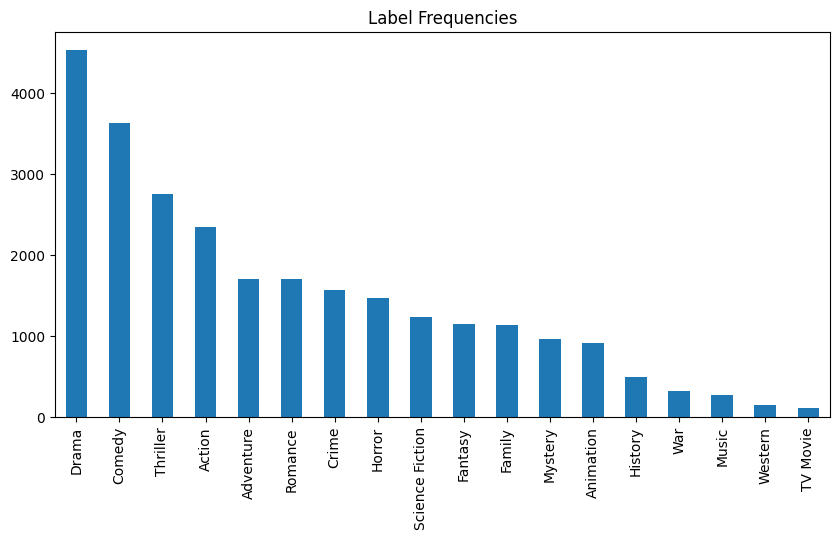

In [15]:
#
review_results(results, pipe_overview, pipe_title_overview, data_overview_split, data_title_overview_split)

In [16]:
'''
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

cls = MultiOutputClassifier(RandomForestClassifier())
cls.fit(x_train, y_train)
'''

'\nfrom sklearn.multioutput import MultiOutputClassifier\nfrom sklearn.ensemble import RandomForestClassifier\n\ncls = MultiOutputClassifier(RandomForestClassifier())\ncls.fit(x_train, y_train)\n'

In [17]:
'''
y_valid_pred = cls.predict(x_val)
y_valid_pred_f = pd.DataFrame(y_valid_pred, columns=y.columns)
'''

'\ny_valid_pred = cls.predict(x_val)\ny_valid_pred_f = pd.DataFrame(y_valid_pred, columns=y.columns)\n'

In [18]:
'''
from sklearn.metrics import classification_report

print("📊 Validation Results:")
for col in y.columns:
    print(f"\n--- {col} ---")
    print(classification_report(y_val[col], y_valid_pred_f[col]))
    '''

'\nfrom sklearn.metrics import classification_report\n\nprint("📊 Validation Results:")\nfor col in y.columns:\n    print(f"\n--- {col} ---")\n    print(classification_report(y_val[col], y_valid_pred_f[col]))\n    '

In [19]:
'''
y_test_pred = cls.predict(x_test)
print("📊 Test Results:")
for col in y.columns:
    print(f"\n--- {col} ---")
    print(classification_report(y_test[col], y_test_pred[:, y.columns.get_loc(col)]))
'''

'\ny_test_pred = cls.predict(x_test)\nprint("📊 Test Results:")\nfor col in y.columns:\n    print(f"\n--- {col} ---")\n    print(classification_report(y_test[col], y_test_pred[:, y.columns.get_loc(col)]))\n'

In [20]:
'''
from sklearn.metrics import accuracy_score

# Label-wise exact match
print("Exact Match Accuracy (Validation):", accuracy_score(y_val, y_valid_pred))
'''

'\nfrom sklearn.metrics import accuracy_score\n\n# Label-wise exact match\nprint("Exact Match Accuracy (Validation):", accuracy_score(y_val, y_valid_pred))\n'

In [21]:
'''

joblib.dump(cls, "multi_label_model.pkl")
#Would Comments on what to do next
'''


'\n\njoblib.dump(cls, "multi_label_model.pkl")\n#Would Comments on what to do next\n'

In [23]:
print(y.value_counts())

Action  Adventure  Animation  Comedy  Crime  Drama  Family  Fantasy  History  Horror  Music  Mystery  Romance  Science Fiction  TV Movie  Thriller  War  Western
0       0          0          0       0      1      0       0        0        0       0      0        0        0                0         0         0    0          577
                              1       0      0      0       0        0        0       0      0        0        0                0         0         0    0          571
                              0       0      1      0       0        0        0       0      0        1        0                0         0         0    0          355
                              1       0      1      0       0        0        0       0      0        0        0                0         0         0    0          341
                                             0      0       0        0        0       0      0        1        0                0         0         0    0          337